In [ ]:
%load_ext autoreload
%autoreload 2

from agents import banditagents
from environments import bandits
import utils

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
sns.set_theme(style="whitegrid", palette="pastel")

##  Run Solvers

In [58]:
configs_dir = '/Users/juliomartinez/Documents/PhD/socialmotivation/configs'
num_episodes = 50

solvers = ['GreedyAgent', 'EpsilonGreedyAgent']
environment = 'TwoArmBandit'

bandit_config_filename = os.path.join(configs_dir, environment + '.yaml')
bandit_config = utils.get_config(bandit_config_filename)
env = bandits.Bandit(bandit_config)
num_iterations = 1000

results_column_names = ['episode','iteration','solver','reward_demonstrator','reward_learner','chosen_arm_id_demonstrator','chosen_arm_id_learner']
#results_column_name = ['episode', 'iteration', 'solver', 'agent', 'reward', 'best_arm_id']
#best_arm_dist_column_names = ['solver', 'num_episodes', 'num_iterations', 'prob_arm1', 'prob_arm2']


for i, solver in enumerate(solvers):
 
    # Get solver class 
    agentClass = getattr(banditagents, solver)
    
    # Get config file
    agents_config_filename = os.path.join(configs_dir, solver + '.yaml')
    agents_config = utils.get_config(agents_config_filename)

    demonstrator_best_arm_distribution = np.zeros(env.num_arms)
    learner_best_arm_distribution = np.zeros(env.num_arms)

    for episode_j in range(num_episodes):
        # run demonstrator
        demonstrator = agentClass(agents_config['demonstrator'])   
        demonstrator(env)
        
        # run learner
        learner = agentClass(agents_config['learner'])
        learner(env, demonstrator)

        # store results
        demonstrator_best_arm_distribution[demonstrator.best_arm_id]=+1
        learner_best_arm_distribution[learner.best_arm_id]=+1

        num_iterations = len(demonstrator.reward_history)
        iterations = list(range(num_iterations))
        episodes = [episode_j]*num_iterations
        solvers_ = [solver]*num_iterations
        trial_df = pd.DataFrame(list(zip(episodes, iterations, solvers_, demonstrator.reward_history,learner.reward_history, demonstrator.arm_id_history, learner.arm_id_history)), columns=results_column_names)
        if i < 1 and episode_j < 1:
            results_df = trial_df.copy()
        else:
            results_df = pd.concat([results_df,trial_df],join='inner', ignore_index=True)

    demonstrator_best_arm_distribution = demonstrator_best_arm_distribution / np.sum(demonstrator_best_arm_distribution)
    learner_best_arm_distribution = learner_best_arm_distribution / np.sum(learner_best_arm_distribution)
    solver_df = pd.DataFrame({
        'solver':solver, 
        'num_episodes': num_episodes, 
        'num_iterations': num_iterations, 
        'demonstrator_prob_arm0':demonstrator_best_arm_distribution[0],
        'demonstrator_prob_arm1':demonstrator_best_arm_distribution[1], 
        'learner_prob_arm0':learner_best_arm_distribution[0],
        'learner_prob_arm1':learner_best_arm_distribution[1]
        }, index=[0])
    if i < 1:
        arm_dist_df = solver_df.copy()
    else:
        arm_dist_df = pd.concat([arm_dist_df,solver_df],axis=0)

results_df.to_csv('/Users/juliomartinez/Documents/PhD/socialmotivation/results.csv')

## Run Analysis

In [59]:
results_df['cumulative_reward_demonstrator'] = results_df.groupby(['solver','episode'])['reward_demonstrator'].cumsum()
results_df['cumulative_reward_learner'] = results_df.groupby(['solver','episode'])['reward_learner'].cumsum()

results_df

,episode,iteration,solver,reward_demonstrator,reward_learner,chosen_arm_id_demonstrator,chosen_arm_id_learner,cumulative_reward_demonstrator,cumulative_reward_learner
0,0,0,GreedyAgent,1.0,0.0,0,1,1.0,0.0
1,0,1,GreedyAgent,1.0,0.0,0,1,2.0,0.0
2,0,2,GreedyAgent,1.0,0.0,0,2,3.0,0.0
3,0,3,GreedyAgent,0.0,1.0,1,1,3.0,1.0
4,0,4,GreedyAgent,1.0,0.0,0,2,4.0,1.0
...,...,...,...,...,...,...,...,...,...
99995,49,995,EpsilonGreedyAgent,0.0,1.0,0,0,588.0,528.0
99996,49,996,EpsilonGreedyAgent,1.0,0.0,0,0,589.0,528.0
99997,49,997,EpsilonGreedyAgent,1.0,1.0,0,0,590.0,529.0
99998,49,998,EpsilonGreedyAgent,0.0,1.0,0,0,590.0,530.0


## Format Data for Visualization

In [68]:
results_long_df = pd.wide_to_long(
    results_df, 
    stubnames=['reward', 'chosen_arm_id', 'cumulative_reward'], 
    i=['episode', 'iteration', 'solver'], 
    j='agent',
    sep='_', 
    suffix=r'\w+')
results_long_df

reward  chosen_arm_id  \
episode iteration solver             agent                                 
0       0         GreedyAgent        demonstrator     1.0              0   
                                     learner          0.0              1   
        1         GreedyAgent        demonstrator     1.0              0   
                                     learner          0.0              1   
        2         GreedyAgent        demonstrator     1.0              0   
...                                                   ...            ...   
49      997       EpsilonGreedyAgent learner          1.0              0   
        998       EpsilonGreedyAgent demonstrator     0.0              0   
                                     learner          1.0              0   
        999       EpsilonGreedyAgent demonstrator     1.0              0   
                                     learner          0.0              0   

                                                   cumulative_reward  
episode iteration solver             agent                            
0       0         GreedyAgent        demonstrator                1.0  
                                     learner                     0.0  
        1         GreedyAgent        demonstrator                2.0  
                                     learner                     0.0  
        2         GreedyAgent        demonstrator                3.0  
...                                                              ...  
49      997       EpsilonGreedyAgent learner                   529.0  
        998       EpsilonGreedyAgent demonstrator              590.0  
                                     learner                   530.0  
        999       EpsilonGreedyAgent demonstrator              591.0  
                                     learner                   530.0  

[200000 rows x 3 columns]

## Display Plots

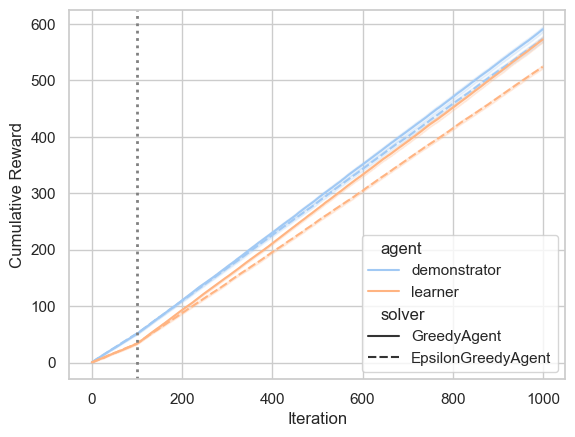

In [71]:
sns.lineplot(data=results_long_df, x="iteration", y="cumulative_reward", hue="agent", style="solver")
plt.ylabel('Cumulative Reward')
plt.xlabel('Iteration')
plt.axvline(x=100, ls=':', lw=2, label='number of initial iterations', color='grey')
plt.show()